Notebook to implement u-net background subtraction

In [1]:
%matplotlib inline

import os
import wandb
import random
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn 
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np
import matplotlib.image as mpimg
from torchvision import utils as tvu



In [2]:
# Choose device to run on

print(torch.__version__)

if(torch.backends.mps.is_available()):
    device = "mps"
elif(torch.cuda.is_available()):
    device = "cuda"
else:
    device = "cpu"

print(f"Running on {device}...")


2.5.1
Running on cuda...


In [3]:
#clear out gpu memory:

with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
%pip install wandb -qU

In [4]:
# set seed value for repeatability

seed = 42
random.seed(seed)  # Python's random module
torch.manual_seed(seed)  # PyTorch CPU/GPU seed
np.random.seed(seed)  # NumPy random seed

In [5]:
# Start loading up the data

# TODO: update base_path to point to wherever your data is stored
base_path = "../../Data/data/"

train_features = pd.read_csv(f"{base_path}train_features.csv", index_col="id")
test_features = pd.read_csv(f"{base_path}test_features.csv", index_col="id")
train_labels = pd.read_csv(f"{base_path}train_labels.csv", index_col="id")



In [6]:
# Add a 'filepath' column with the full path to each image
# Subdirectories for train and test images
train_images_path = os.path.join(base_path, "train_features")
test_images_path = os.path.join(base_path, "test_features")

train_features['filepath'] = train_features.index.map(
    lambda img_id: os.path.join(train_images_path, f"{img_id}.jpg"))

test_features['filepath'] = test_features.index.map(
    lambda img_id: os.path.join(test_images_path, f"{img_id}.jpg"))

In [7]:
species_labels = sorted(train_labels.columns.unique())


We start diverging from the "standard" example provided by the competition here. Let's pull out all the blank images from the train dataset. Then we'll test/train split on that for training the U-Net.

In [8]:
blank_training_labels = train_labels[train_labels["blank"]==1]

blank_training_images = train_features.loc[blank_training_labels.index]


Since we're only using one class here, this is more of an unsupervised activity than a supervised one. As such, we only have

In [9]:
X_train, X_test = train_test_split(blank_training_images, test_size=0.2, random_state=42)

In [ ]:
print(X_train.loc['ZJ006397', "filepath"])

print(X_train.index[874])

In [10]:
# Choose batch size here:
BATCH_SIZE = 8

class BackgroundDataset(Dataset):

    def __init__(self, train_features, transform = None, device=device):
        self.data = train_features
        self.device = device
        self.transform = transform

    def __getitem__(self, index):
        image_id = self.data.index[index]
        image = Image.open(self.data.loc[image_id,"filepath"]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        sample = {"image_id": image_id, "image": image}

        return sample
    
    def __len__(self):
        return len(self.data)
    

background_transform_input = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

background_transform_target = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])


In [11]:
# Create datasets
input_dataset = BackgroundDataset(X_train, transform=background_transform_input, device=device)
target_dataset =BackgroundDataset(X_train, transform=background_transform_target, device=device)
test_dataset =  BackgroundDataset(X_test, transform= background_transform_target, device=device)




pin = False if device=="cuda" else True

train_loader = DataLoader(
    input_dataset,
    batch_size = BATCH_SIZE, 
    shuffle = False,
    pin_memory = pin
)

test_loader = DataLoader(
    test_dataset, 
    batch_size = BATCH_SIZE,
    shuffle = True,
    pin_memory = pin
)



Ok, lets start working on building the U-Net itself. 

In [12]:
# guided by: https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py

class DownConvolve(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.down = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, kernel_size=3, padding=1), #need to add padding so our input doesn't become too small through encoder
            nn.BatchNorm2d(out_channels), # batch norms not in original paper, but adding for grad flow
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, padding=1), #need to add padding so our input doesn't become too small through encoder, actually, mayeb we just need to remove a layer
            nn.BatchNorm2d(out_channels), # batch norms not in original paper, but adding for grad flow
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

    def forward(self, x):
            return self.down(x)

class UpConvolve(nn.Module):

    def __init__(self, in_channels, out_channels):

        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels

        self.up = nn.Sequential(
            nn.Conv2d(self.in_channels, self.in_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(in_channels), # batch norms not in original paper, but adding for grad flow
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(self.in_channels, self.in_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(in_channels), # batch norms not in original paper, but adding for grad flow
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.ConvTranspose2d(self.in_channels, self.out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x, skip_x):

        x = self.up(x)

        # need to adjust x so that it "fits" with the tensor from skip connection
        height_x, width_x = x.shape[2], x.shape[3]
        height_skip_x, width_skip_x = skip_x.shape[2], skip_x.shape[3]
        height_diff = height_skip_x - height_x
        width_diff = width_skip_x - width_x

        #print(f"Input shape: {x.shape}")
        #print(f"Residual shape: {skip_x.shape}")
        #print(f"height difference: {height_diff}, padding by: {height_diff//2}")
        #print(f"weidth difference: {width_diff}, padding by: {width_diff//2}")

        padded_x = F.pad(x, (width_diff//2, width_diff//2, height_diff//2, height_diff//2))
        
        #print(f"Skip X has size: {skip_x.shape}, Padded_x has shape: {padded_x.shape}")

        out = torch.cat((skip_x, padded_x), dim=1)

        return out


In [14]:


class UnetModel(nn.Module):

    def __init__(self, input_channel_count, output_class_count):
        super().__init__()

        self.input_channel_count = input_channel_count
        self.output_channel_count = output_class_count

        self.final_up_conv = nn.ConvTranspose2d(128, self.output_channel_count, kernel_size=2, stride=2)

        self.down_layer_1 = DownConvolve(self.input_channel_count, 64)
        self.down_layer_2 = DownConvolve(64, 128)
        self.down_layer_3 = DownConvolve(128, 256)
        self.down_layer_4 = DownConvolve(256, 512)
        self.down_layer_5 = DownConvolve(512, 1024)

        self.up_layer_1 = UpConvolve(1024, 512)
        self.up_layer_2 = UpConvolve(512*2, 256)
        self.up_layer_3 = UpConvolve(256*2, 128)
        self.up_layer_4 = UpConvolve(128*2, 64)
        
    def forward(self, x):
        #print(f"Shape of x: {x.shape}")
        d1 = self.down_layer_1(x)
        #print(f"Shape of d1: {d1.shape}")
        d2 = self.down_layer_2(d1)
        #print(f"Shape of d2: {d2.shape}")
        d3 = self.down_layer_3(d2)
        #print(f"Shape of d3 is: {d3.shape}")
        d4 = self.down_layer_4(d3)
        #print(f"Shape of d4 is: {d4.shape}")
        d5 = self.down_layer_5(d4)
        #print(f"Shape of d5 is: {d5.shape}")

        u1 = self.up_layer_1(d5, d4)
        #print(f"Shape of u1: {u1.shape}")
        u2 = self.up_layer_2(u1, d3) 
        #print(f"Shape of u2: {u2.shape}")
        u3 = self.up_layer_3(u2, d2)
        #print(f"Shape of u3: {u3.shape}")
        u4 = self.up_layer_4(u3, d1)
        #print(f"Shape of u4: {u4.shape}")

        out = self.final_up_conv(u4)
        
        return out
        



In [15]:
LEARNING_RATE = 1e-3
BETA_VALUES = (0.9, 0.99)
EPOCHS=3



unet = UnetModel(3,3).to(device)
criteria = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=LEARNING_RATE, betas=BETA_VALUES)


In [16]:
def train_one_epoch(model, train_loader, input_transform, criterion, optimizer, epoch):
    """
    Train the model for one epoch.

    Args:
        model (nn.Module): The model being trained.
        train_loader (DataLoader): DataLoader for training data.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        epoch (int): Current epoch number.
        cfg (dict): W&B configuration.

    Returns:
        float: Average loss for all batches in the epoch. Summarizing how 
        the model is performing during this epoch
    """
    print(f"Starting training for epoch {epoch}")
    model.train()
    total_loss = 0
    # total_steps = len(train_loader) # num batches in loader
    tracking_loss = []  # List to store loss for every batch

    for batch_n, batch in enumerate(train_loader):
        images = input_transform(batch["image"]).to(device)
        labels = batch["image"].to(device) # to train this, we use the empty frames as both inputs and ground truth labels

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        tracking_loss.append(loss.item())  # Store batch loss for tracking 

        # backward and optimize
        optimizer.zero_grad()
        loss.backward() # wrt
        optimizer.step()


        # Print progress every 10 batches
        if (batch_n + 1 ) % 10 == 0: 
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                .format(epoch+1, EPOCHS, batch_n+1, len(train_loader), loss.item()))
            
    avg_loss = total_loss / len(train_loader)

    return avg_loss, tracking_loss


In [17]:
def evaluate(model, val_loader, criterion, log_counter):
    """
    Evaluate the model on a test/validation dataset.

    Args:
        model (nn.Module): The model to evaluate.
        test_loader (DataLoader): DataLoader for test data.
        criterion (nn.Module): Loss function.
        cfg (dict): W&B configuration.

    Returns:
        dict: Metrics including accuracy and average loss.
    """
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    log_counter = 0

    # Collect all predictions and labels for metric calculations
    all_outputs = []
    all_ids = []


    
    with torch.no_grad():
        for batch_n, batch in enumerate(val_loader):
            images = batch["image"].to(device)
            labels = batch["image"].to(device)
            image_ids = batch["image_id"]

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            all_outputs.append(outputs)
            all_ids.append(all_ids)
            



    # Calculate metrics
    avg_loss = total_loss / len(val_loader)
    print(f"Evaluation - Loss: {avg_loss:.4f}")

    return all_outputs[:-5], all_ids[:-5]
    


In [18]:
log_counter = 0
tracking_loss_all = []
#t = transforms.RandomErasing(p=1, scale=(0.02, 0.9), ratio=(0.03, 3.3), value=(np.random.randint(0,255),np.random.randint(0,255),np.random.randint(0,255)))
t = transforms.RandomErasing(p=1, scale=(0.02, 0.9), ratio=(0.03, 3.3), value=(0))

for epoch in range(EPOCHS):
    #Training step
    avg_train_loss, tracking_loss = train_one_epoch(unet, 
                                     train_loader,
                                     t,
                                     criteria, 
                                     optimizer, 
                                     epoch)
    tracking_loss_all.extend(tracking_loss)  # Append to global list
    print(f"Epoch {epoch+1}/{EPOCHS} - Avg Train Loss: {avg_train_loss:.4f}")

    
    


Starting training for epoch 0
Epoch [1/3], Step [10/222], Loss: 1.0675
Epoch [1/3], Step [20/222], Loss: 0.5464
Epoch [1/3], Step [30/222], Loss: 0.4225
Epoch [1/3], Step [40/222], Loss: 0.3681
Epoch [1/3], Step [50/222], Loss: 0.3429
Epoch [1/3], Step [60/222], Loss: 0.2820
Epoch [1/3], Step [70/222], Loss: 0.2084
Epoch [1/3], Step [80/222], Loss: 0.1854
Epoch [1/3], Step [90/222], Loss: 0.1882
Epoch [1/3], Step [100/222], Loss: 0.1717
Epoch [1/3], Step [110/222], Loss: 0.1863
Epoch [1/3], Step [120/222], Loss: 0.1321
Epoch [1/3], Step [130/222], Loss: 0.1326
Epoch [1/3], Step [140/222], Loss: 0.1525
Epoch [1/3], Step [150/222], Loss: 0.1310
Epoch [1/3], Step [160/222], Loss: 0.1115
Epoch [1/3], Step [170/222], Loss: 0.1167
Epoch [1/3], Step [180/222], Loss: 0.1133
Epoch [1/3], Step [190/222], Loss: 0.1480
Epoch [1/3], Step [200/222], Loss: 0.0816
Epoch [1/3], Step [210/222], Loss: 0.1096
Epoch [1/3], Step [220/222], Loss: 0.0949
Epoch 1/3 - Avg Train Loss: 0.3289
Starting training fo

In [19]:
torch.save(unet.state_dict(), "trained_unet.pth")

In [20]:
# Evaluation step
backgrounds, ids = evaluate(unet, test_loader, criteria, log_counter)


Evaluation - Loss: 0.0193


In [21]:
torch.cuda.empty_cache()

Shape of backgrounds is: 51
0
1
2
3


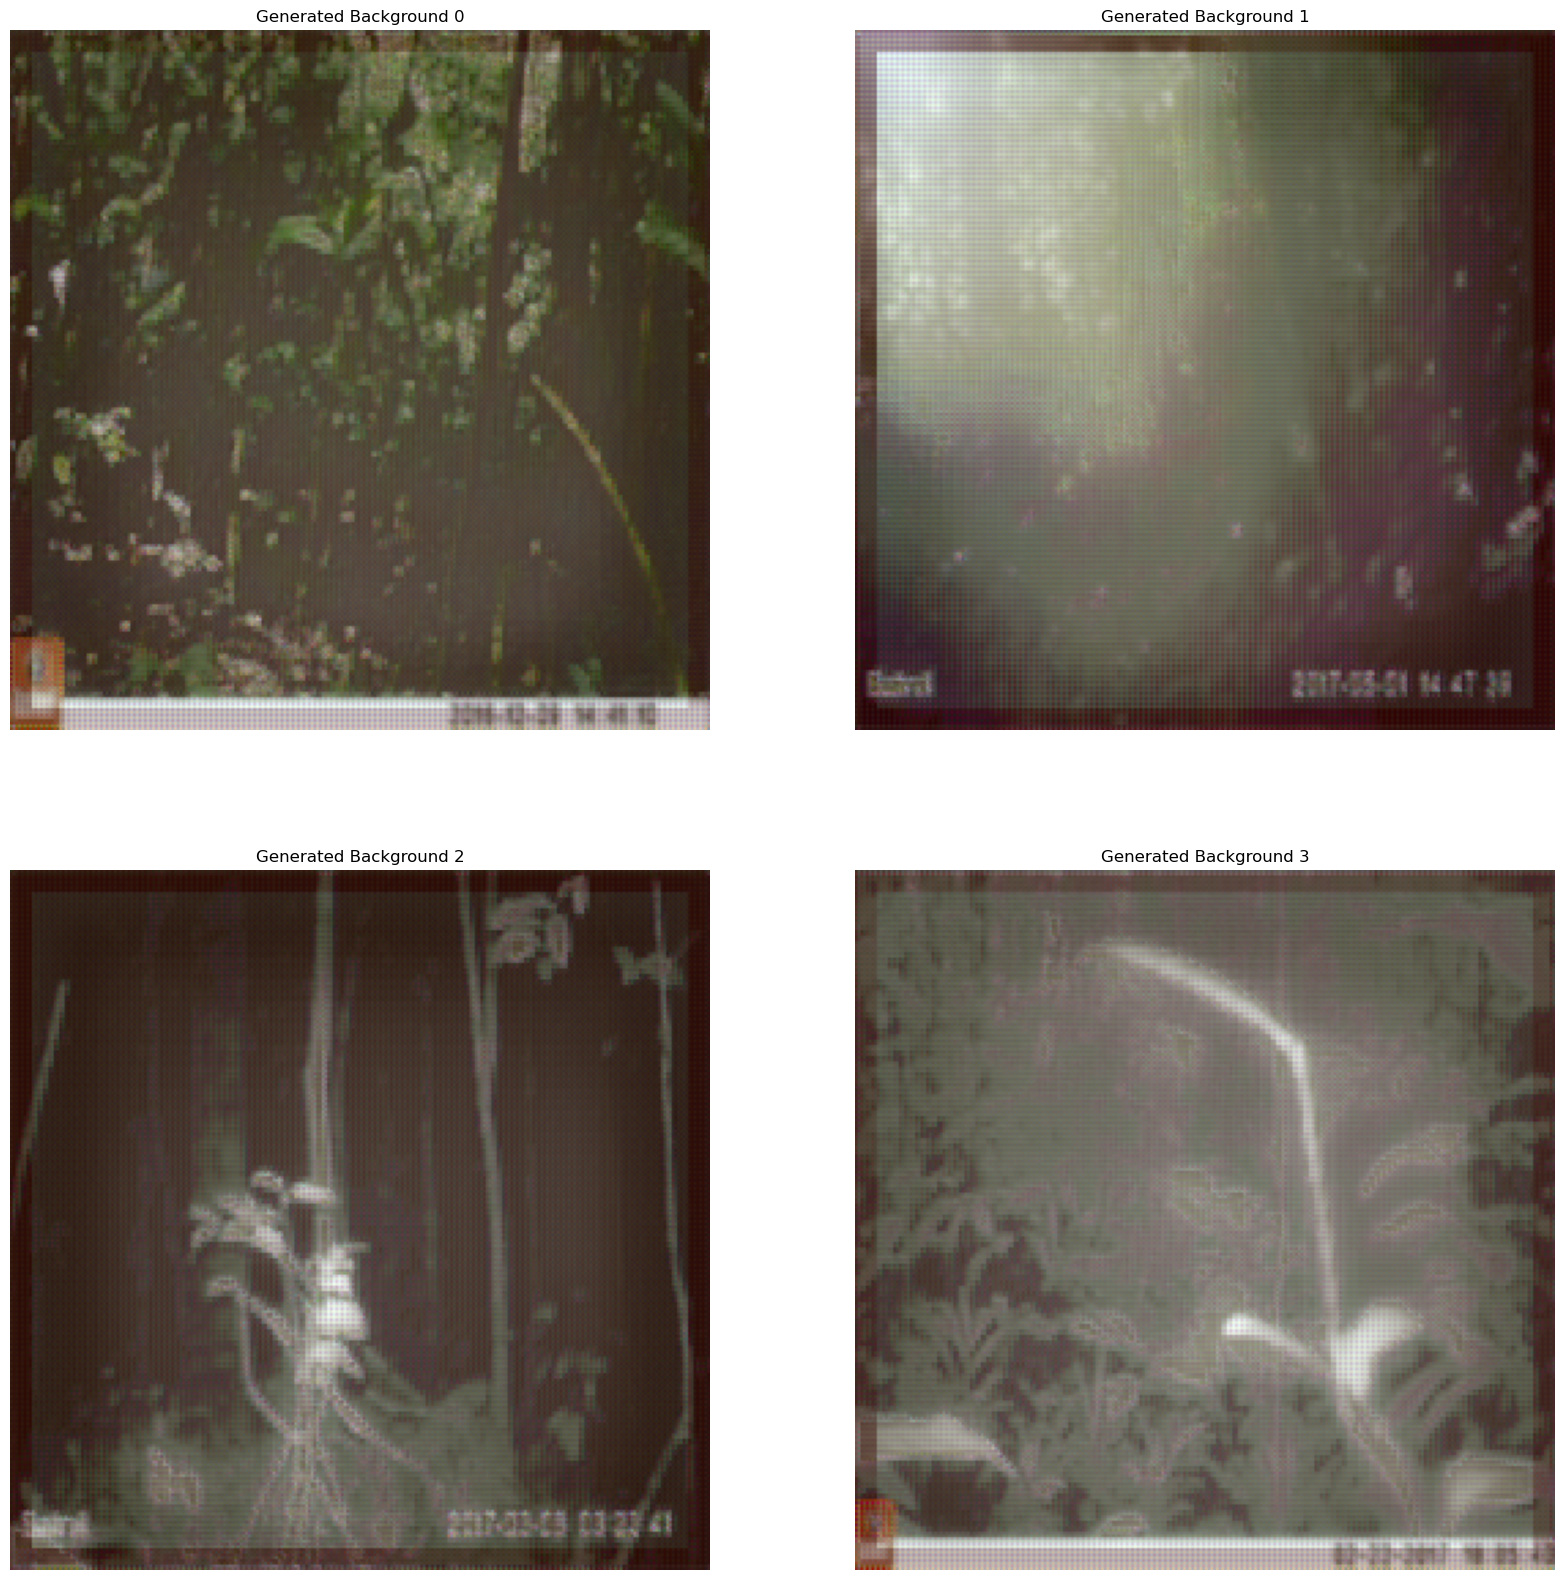

In [22]:
im = backgrounds[0]
print(f"Shape of backgrounds is: {len(backgrounds)}")

def prep_picture(image_tensor, index):
    im = image_tensor[index,:,:,:]
    image = np.transpose(im.cpu().numpy(), (1,2,0))
    min_val = image.min()
    max_val = image.max()
    normalized_image = (image-min_val)/(max_val-min_val)
    return normalized_image

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,20))

for idx, ax in enumerate(axes.flat):
    print(idx)
    image = prep_picture(im, idx)
    ax.imshow(image)
    ax.set_title(f"Generated Background {idx}")
    ax.axis("off")

plt.show()


In [ ]:
# only run this if loading pretrained model:

unet = UnetModel(3,3)
unet.load_state_dict(torch.load("trained_unet.pth"))
unet.eval()
unet.to(device)

unet.eval()

In [23]:
class PreprocessingData(Dataset):

    def __init__(self, train_features, transform = None, device=device):
        self.data = train_features
        self.device = device
        self.transform = transform

    def __getitem__(self, index):
        image_id = self.data.index[index]
        image = Image.open(self.data.loc[image_id,"filepath"]).convert("RGB")

        if self.transform:
            image = self.transform(image)

        sample = {"image_id": image_id, "image": image}

        return sample
    
    def __len__(self):
        return len(self.data)
    

preprocessing_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()
])


# Create datasets
train_dataset = PreprocessingData(train_features, transform=preprocessing_transform, device=device)
test_dataset =  PreprocessingData(test_features,  transform=preprocessing_transform, device=device)


pin = False if device=="cuda" else True

batch_size_train = len(train_dataset)
batch_size_test =  len(test_dataset)

batch_size=1

train_loader = DataLoader(
    train_dataset, 
    batch_size = batch_size, 
    shuffle = False,
    pin_memory = pin
)

test_loader = DataLoader(
    test_dataset, 
    batch_size = batch_size,
    shuffle = False,
    pin_memory = pin
)




In [24]:
def preprocess_with_unet(train_loader, pre_trained_model):
    
    preprocessed_train_data = []
    preprocessed_train_labels = []
    backgrounds = []

    trans = transforms.Resize((224, 224))

    with torch.no_grad():

        for idx, datapoint in enumerate(train_loader):
            data = datapoint["image"].to(device)
            id = datapoint["image_id"]
            out = pre_trained_model(data)
            resized_out = trans(out)
            background_subtract = torch.subtract(trans(data), resized_out)
            preprocessed_train_data.append(background_subtract)
            preprocessed_train_labels.append(id)
            backgrounds.append(resized_out)
            torch.cuda.empty_cache()
            path = base_path+"/preprocessed_training_images/{}".format(preprocessed_train_labels[idx][0])+".jpg"
            tvu.save_image(background_subtract, path)
            path = base_path+"/preprocessed_training_backgrounds/{}".format(preprocessed_train_labels[idx][0])+".jpg"
            tvu.save_image(backgrounds[idx], path)

            if (idx + 1 ) % 100 == 0:
                print(f"Processed {idx} images...")


        return preprocessed_train_data, preprocessed_train_labels, backgrounds


preprocessed_training_data, preprocessed_train_labels, backgrounds = preprocess_with_unet(test_loader, unet)
torch.cuda.empty_cache()

for idx, preprocessed_image in enumerate(preprocessed_training_data):
    path = base_path+"/preprocessed_testing_images/{}".format(preprocessed_train_labels[idx][0])+".jpg"
    tvu.save_image(preprocessed_image, path)
    path = base_path+"/preprocessed_testing_backgrounds/{}".format(preprocessed_train_labels[idx][0])+".jpg"
    tvu.save_image(backgrounds[idx], path)



# preprocessed_test_data, preprocessed_test_labels, backgrounds = preprocess_with_unet(test_loader, unet)
# torch.cuda.empty_cache()

# for idx, preprocessed_image in enumerate(preprocessed_test_data):
#     path = base_path+"/preprocessed_testing_images/{}".format(preprocessed_test_labels[idx][0])+".jpg"
#     tvu.save_image(preprocessed_image, path)
#     path = base_path+"/preprocessed_testing_backgrounds/{}".format(preprocessed_test_labels[idx][0])+".jpg"
#     tvu.save_image(backgrounds[idx], path)







Processed 99 images...
Processed 199 images...
Processed 299 images...
Processed 399 images...
Processed 499 images...
Processed 599 images...
Processed 699 images...
Processed 799 images...
Processed 899 images...
Processed 999 images...
Processed 1099 images...
Processed 1199 images...
Processed 1299 images...
Processed 1399 images...
Processed 1499 images...
Processed 1599 images...
Processed 1699 images...
Processed 1799 images...
Processed 1899 images...
Processed 1999 images...
Processed 2099 images...
Processed 2199 images...
Processed 2299 images...
Processed 2399 images...
Processed 2499 images...
Processed 2599 images...
Processed 2699 images...
Processed 2799 images...
Processed 2899 images...
Processed 2999 images...
Processed 3099 images...
Processed 3199 images...
Processed 3299 images...
Processed 3399 images...
Processed 3499 images...
Processed 3599 images...
Processed 3699 images...
Processed 3799 images...
Processed 3899 images...
Processed 3999 images...
Processed 4

In [25]:
# Add a 'filepath' column with the full path to each image
# Subdirectories for train and test images
train_images_path = os.path.join(base_path, "preprocessed_training_images")
test_images_path = os.path.join(base_path, "preprocessed_testing_images")

train_features['filepath'] = train_features.index.map(
    lambda img_id: os.path.join(train_images_path, f"{img_id}.jpg"))

test_features['filepath'] = test_features.index.map(
    lambda img_id: os.path.join(test_images_path, f"{img_id}.jpg"))

From here, lets just plug in the benchmark code to see if it works

In [26]:
from sklearn.model_selection import train_test_split

frac = 0.5

y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

In [27]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values,
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [28]:
from torch.utils.data import DataLoader

train_dataset = ImagesDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32)

In [ ]:
from torch import nn
import torchvision.models as models

# model = models.resnet50(pretrained=True) fixed warning
# model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
# model.fc = nn.Sequential(
#     nn.Linear(2048, 100),  # dense layer takes a 2048-dim input and outputs 100-dim
#     nn.ReLU(inplace=True),  # ReLU activation introduces non-linearity
#     nn.Dropout(0.1),  # common technique to mitigate overfitting
#     nn.Linear(
#         100, 8
#     ),  # final dense layer outputs 8-dim corresponding to our target classes
# )

num_classes = 8

model = models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.IMAGENET1K_V1)
in_features = model.classifier[1].in_features  # Get input size of the final layer
model.classifier = nn.Sequential(
    nn.Dropout(p=0.1, inplace=True),
    nn.Linear(in_features=in_features, out_features=num_classes)
)

model = model.to(device)


In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [31]:
num_epochs = 1

tracking_loss = {}

for epoch in range(1, num_epochs + 1):
    print(f"Starting epoch {epoch}")

    # iterate through the dataloader batches. tqdm keeps track of progress.
    for batch_n, batch in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):

        # 1) zero out the parameter gradients so that gradients from previous batches are not used in this step
        optimizer.zero_grad()

        # 2) run the forward step on this batch of images
        outputs = model(batch["image"])

        # 3) compute the loss
        loss = criterion(outputs, batch["label"])
        # let's keep track of the loss by epoch and batch
        tracking_loss[(epoch, batch_n)] = float(loss)

        # 4) compute our gradients
        loss.backward()
        # update our weights
        optimizer.step()

Starting epoch 1


 21%|██        | 40/194 [03:17<12:39,  4.93s/it]


KeyboardInterrupt: 

In [ ]:
tracking_loss = pd.Series(tracking_loss)

plt.figure(figsize=(10, 5))
tracking_loss.plot(alpha=0.2, label="loss")
tracking_loss.rolling(center=True, min_periods=1, window=10).mean().plot(
    label="loss (moving avg)"
)
plt.xlabel("(Epoch, Batch)")
plt.ylabel("Loss")
plt.legend(loc=0)
plt.show()

In [29]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

In [32]:
from torch import nn
preds_collector = []

# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"])
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████| 65/65 [01:06<00:00,  1.02s/it]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ010593,0.129832,0.079741,0.125257,0.216450,0.069645,0.107036,0.133416,0.138623
ZJ008057,0.135797,0.092568,0.137793,0.178094,0.083618,0.129841,0.125118,0.117170
ZJ005326,0.151114,0.110766,0.127076,0.132084,0.088428,0.126328,0.151652,0.112552
ZJ013073,0.082692,0.038828,0.091775,0.453112,0.030011,0.059297,0.083809,0.160476
ZJ008733,0.151613,0.091706,0.118579,0.162191,0.070735,0.128897,0.166322,0.109957
...,...,...,...,...,...,...,...,...
ZJ013009,0.143112,0.105311,0.124249,0.143895,0.084904,0.123357,0.152951,0.122220
ZJ008801,0.107594,0.056501,0.116386,0.316403,0.049768,0.078193,0.111116,0.164039
ZJ014619,0.149384,0.112647,0.130389,0.128638,0.083462,0.120323,0.159389,0.115767
ZJ003923,0.071433,0.030696,0.077357,0.539494,0.024054,0.049421,0.070742,0.136802


In [33]:
print("True labels (training):")
y_train.idxmax(axis=1).value_counts()
print("Predicted labels (eval):")
eval_preds_df.idxmax(axis=1).value_counts()
print("True labels (eval):")
y_eval.idxmax(axis=1).value_counts()
eval_predictions = eval_preds_df.idxmax(axis=1)
eval_predictions.head()
eval_true = y_eval.idxmax(axis=1)

(eval_true == "monkey_prosimian").sum() / len(eval_predictions)

correct = (eval_predictions == eval_true).sum()
accuracy = correct / len(eval_predictions)
accuracy

True labels (training):
Predicted labels (eval):
True labels (eval):


0.2954876273653566